# 3.2 线性回归的从零开始实现

In [1]:
#从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器
#这一节中只使用张量和自动求导

%matplotlib inline
import random
import torch
from d2l import torch as d2l

D:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 3.2.1 生成数据集

In [2]:
#将带有噪声的线性模型构造一个人造数据集，我们的任务是使用这个有限样本的数据集来回复这个模型的参数
#我们将使用低维数据，这样可以很容易地将其可视化。
#在下面的代码中，我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布重采样的2个特征。

def synthetic_data(w, b, num_examples): #@save
    '''生成y=Xw+b+噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))
    #torch.normal:返回一个张量，包含从给定参数means,std的离散正态分布中抽取随机数。
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
#features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）。

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.2914,  1.2997]) 
label: tensor([-0.8097])


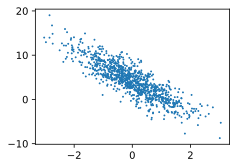

In [4]:
#通过生成第二个特征features[:1]和labels的散点图，可以直观观察到两者之间的线性关系。
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## 3.2.2读取数据集

In [5]:
#训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
#由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据

#在下面的代码中我们定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
#每个小批量包含一组特征和标签

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #range()函数返回的是一个可迭代对象（类型是对象），而不是列表类型，所以打印的时候不会打印列表。
    #list() 函数是对象迭代器，可以把range()返回的可迭代对象转为一个列表，返回的变量类型为列表。
    random.shuffle(indices)
    #random.shuffle()函数将序列中的元素随机打乱
    #这些样本是随机读取的，没有特定的顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        #Python中，使用了yield的函数被称为生成器generator。调用一个yield函数，就会返回一个生成器对象。

In [6]:
#通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”，每个样本都可以并行地进行模型计算，且每个样本损失的梯度也可以被并行计算
#GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.9615,  0.1788],
        [-1.0793, -1.0146],
        [ 0.7234,  0.3165],
        [-0.7250,  0.9213],
        [ 0.6333,  0.6489],
        [ 0.0736, -0.9271],
        [ 1.8420, -0.8927],
        [-0.8244, -0.0127],
        [-0.5377,  0.4509],
        [-0.6218,  0.5909]]) 
 tensor([[ 7.5180],
        [ 5.4894],
        [ 4.5697],
        [-0.3617],
        [ 3.2641],
        [ 7.4896],
        [10.9225],
        [ 2.5987],
        [ 1.6036],
        [ 0.9556]])


## 3.2.3 初始化模型参数

In [7]:
#当我们开始用小批量随机梯度下降优化我们的模型参数之前，我们需要先有一些参数。
#从均值为0，标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
#初始化参数之后我们的任务是更新参数，直到这些参数足够拟合我们的数据。
#每次更新都需要计算损失函数关于模型参数的梯度。有了这个梯度，我们就可以向减少损失的方向更新每个参数。

## 3.2.4 定义模型

In [9]:
#接下来我们必须定义模型，将模型的输入和参数同模型的输出关联起来
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 3.2.5 定义损失函数

In [10]:
#因为需要计算损失函数的梯度，所以我们应该先定义损失函数
#这里使用平方损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6 定义优化算法

In [11]:
#每一步中使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
#接下来，朝着减少损失的方向更新我们的参数

#下面的函数实现小批量随机梯度下降更新，该函数接受模型参数集合、学习速率和批量大小作为输入
#每一步更新的大小由学习速率lr决定，因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size)来规范化步长
#这样步长大小就不会取决于我们对批量大小的选择

def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
    #with语句适用于对资源进行访问的场合，确保不管使用过程中是否发生异常都会执行必要的“清理”操作，释放资源。
    #torch.no_grad() 在该模块下，所有计算得出的tensor的requires_grad都自动设置为False。
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 3.2.7 训练

In [12]:
#每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测
#计算完损失后，我们开始反向传播，存储每个参数的梯度，最后我们调用优化算法sgd来更新模型参数

In [13]:
#在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集，并将训练数据集中国所有样本都使用一次（假设样本数能够被批量大小整除）

In [14]:
#这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设置为3和0.03

In [17]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) #X和y的小批量损失 
        #因为l的形状是(batch_size, 1),而不是一个标量，l中所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) #使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035601
epoch 2, loss 0.000126
epoch 3, loss 0.000050


In [18]:
#来看看真正的误差
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0006, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


In [19]:
#注意，我们并不应该想当然地认为我们能够完美地求解参数。
#在机器学习中，我们通常不太关心恢复真正的参数，而关心如何高度准确预测参数
#幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解，其中一个原因是在深度网络中存在许多参数组合能够实现高精度的预测

## 3.2.8 小结

In [20]:
#我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。